In [1]:
%matplotlib inline

# Imports
import numpy as np
import pandas as pd
import quandl
quandl.ApiConfig.api_key = '8pWWtKoHwCGQLAxwazCT' # Enter Quandl API key to download stock prices data

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
# Get S&P500 stock symbols, sectors, and subsectors from wikipedia
wiki_table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies',header=0)[0]
symbols = list(wiki_table['Ticker symbol'])
symbols[symbols.index("BKNG")] = 'PCLN' #Updated stock symbol
symbols[symbols.index("WELL")] = 'HCN' #Updated stock symbol
sectors = list(wiki_table['GICS Sector'])
subsectors = list(wiki_table['GICS Sub Industry'])

In [3]:
# Retrieve daily stock prices in 2017
data = []
for s, i in zip(symbols,np.arange(len(symbols))):
    data.append(quandl.get("WIKI/" + s.replace("-", "_"), start_date="2017-01-01", end_date="2017-12-31")) #stored as pandas df

In [4]:
# Build dataframe with stocks as rows, days as columns, daily changes as the values, and add sector and subsector labels
stocks_df = pd.DataFrame(index=symbols, columns=data[3].index) # Use the dates from a stock with data from all 250 trading days
for s, i in zip(data,np.arange(len(data))):
    s['Daily change'] = (s['Adj. Close']-s['Adj. Open'])*100/s['Adj. Open']
    stocks_df.iloc[i,:] = s['Daily change']
    
stocks_df['Sector']=sectors
stocks_df['Subsector']=subsectors

In [5]:
# PCA
stocks_mat = stocks_df.iloc[:,:250].values.astype(float) # convert pd dataframe to numpy array
stocks_mat = np.nan_to_num(stocks_mat) #replace NaNs with 0s
pca = PCA(n_components=2)
scores = pca.fit_transform(stocks_mat)
# Add first 2 PCs to dataframe
stocks_df['PC1'] = scores[:,0]
stocks_df['PC2'] = scores[:,1]

In [6]:
# K Means clustering into 11 clusters
km = KMeans(n_clusters=11, n_jobs=-1)
km_pred = km.fit(stocks_df[['PC1','PC2']])
stocks_df['Cluster'] = km_pred.labels_ # Add the cluster determined by KMeans to stocks_df
stocks_df.head()

Date,2017-01-03 00:00:00,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-09 00:00:00,2017-01-10 00:00:00,2017-01-11 00:00:00,2017-01-12 00:00:00,2017-01-13 00:00:00,2017-01-17 00:00:00,...,2017-12-22 00:00:00,2017-12-26 00:00:00,2017-12-27 00:00:00,2017-12-28 00:00:00,2017-12-29 00:00:00,Sector,Subsector,PC1,PC2,Cluster
MMM,-0.436168,0.162894,-0.308538,0.530205,-0.616696,-0.439783,0.713356,0.265582,-0.106994,0.146893,...,NaN,NaN,NaN,NaN,NaN,Industrials,Industrial Conglomerates,-2.620687,-1.916774,4
ABT,1.07834,0.768049,1.17227,2.7204,-0.122579,1.17618,0.0730816,-0.171611,0.441718,0.565527,...,-0.297723,-0.0175408,0.665616,0.0348189,-0.920139,Health Care,Health Care Equipment,-3.182533,-1.935385,4
ABBV,-0.810553,1.03768,0.615336,-0.142452,0.642633,0.0312256,-3.53424,0.83923,1.04319,0.178138,...,0.142755,-0.407539,0.368362,-0.407373,-1.4571,Health Care,Pharmaceuticals,-3.505858,-3.088557,8
ACN,-0.783779,-0.145411,-1.70115,1.13923,-0.981574,0.104402,0.623917,0.138384,1.38708,0.094893,...,-1.02901,-0.0979496,0.0522057,0.0716799,-0.867707,Information Technology,IT Consulting & Other Services,-3.807645,-0.820874,4
ATVI,0.548847,1.60457,1.17333,-0.105402,-1.02389,1.88479,1.89758,0.359066,0.698035,0,...,-0.539624,-1.22976,-0.518297,0.0947269,-0.424595,Information Technology,Home Entertainment Software,-12.307814,4.103036,2


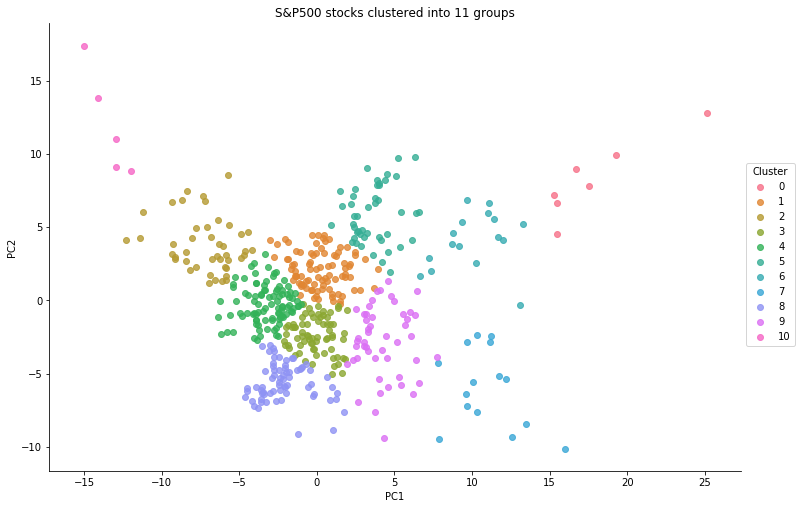

In [7]:
# Visualize clusters predicted by KMeans
sns.lmplot('PC1', 'PC2', data=stocks_df, hue='Cluster', fit_reg=False, size=7,aspect=1.5, palette='husl');
plt.title('S&P500 stocks clustered into 11 groups');

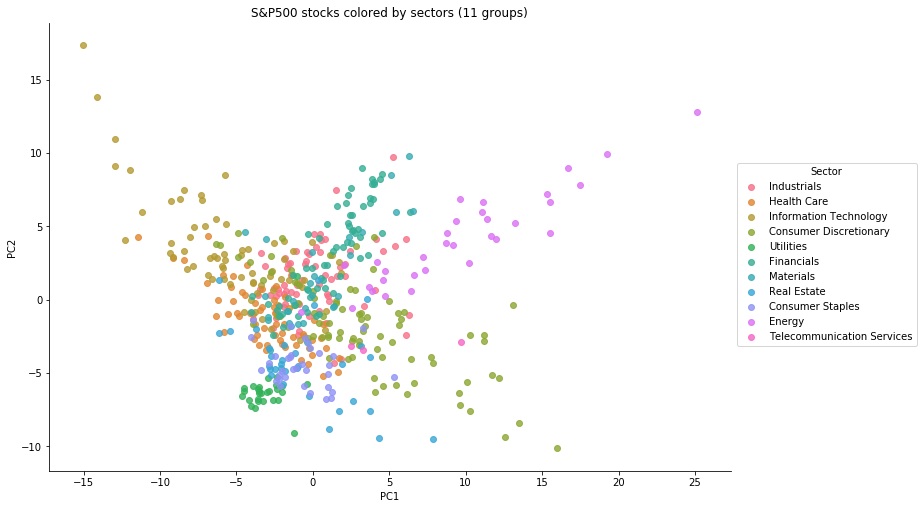

In [9]:
# Visualize stocks on first 2 PCs
sns.lmplot('PC1', 'PC2', data=stocks_df, hue='Sector', fit_reg=False, size=7,aspect=1.5, palette='husl');
plt.title('S&P500 stocks colored by sectors (11 groups)');

Conclusion: Clustering produced by K-means sometimes captures the sector in which the stock belongs, but stocks from different sectors are not completely separated, as seen by their overlap in reduced PC space.